In [11]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [13]:
# Convert pixel values to floats
# Normalize the input image so that each pixel value is between 0 to 1.
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

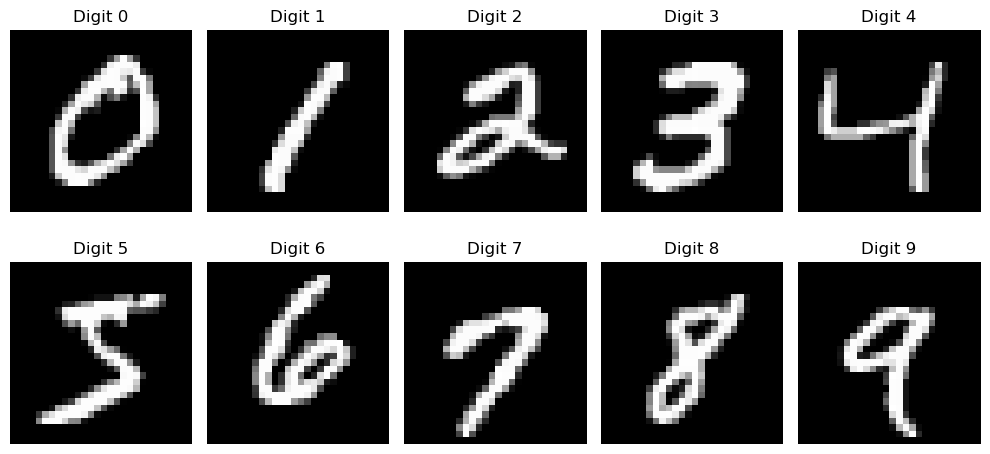

In [14]:
# Convert a subset of the data into a DataFrame
num_samples = 1000
data = {
    'Label': y_train[:num_samples],
    'Pixels': [pixels.flatten() for pixels in x_train[:num_samples]]
}
df = pd.DataFrame(data)

# Plot a sample of the images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(df.loc[df['Label'] == i, 'Pixels'].iloc[0].reshape(28, 28), cmap='gray')
    plt.title(f"Digit {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [15]:
# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

In [16]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5445 - loss: 2.3455 - val_accuracy: 0.4734 - val_loss: 2.3024
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4610 - loss: 2.3023 - val_accuracy: 0.4552 - val_loss: 2.3024
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4410 - loss: 2.3019 - val_accuracy: 0.4215 - val_loss: 2.3026
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4079 - loss: 2.3026 - val_accuracy: 0.4215 - val_loss: 2.3026
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4117 - loss: 2.3026 - val_accuracy: 0.4215 - val_loss: 2.3026


In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4020 - loss: 2.3026  
Test accuracy: 0.42149999737739563


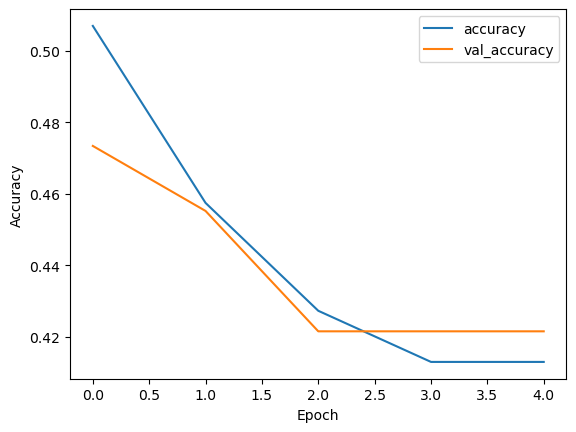

In [19]:
# Visualize training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/kd/9h3yrkps2vj0t9zs17vt349c0000gn/T/tmpsjdmdc8n/assets


INFO:tensorflow:Assets written to: /var/folders/kd/9h3yrkps2vj0t9zs17vt349c0000gn/T/tmpsjdmdc8n/assets


: 

In [21]:
# Save the TensorFlow Lite model to a file
with open('mnist_model.tflite', 'wb') as f:
    f.write(tflite_model)

TypeError: a bytes-like object is required, not '_io.BufferedWriter'

In [ ]:
# Perform post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

In [ ]:
# Save the quantized TensorFlow Lite model to a file
with open('quantized_mnist_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

In [ ]:
def evaluate_inference_accuracy(model_path, quantized=False):
    # Load the MNIST dataset
    (_, _), (x_test, y_test) = mnist.load_data()

    # Convert pixel values to floats and scale them to the range [0, 1]
    x_test = x_test.astype('float32') / 255.0

    if quantized:
        # Load the quantized TensorFlow Lite model
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()

        # Get input and output details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Perform inference on the test data
        correct_count = 0
        for i in range(len(x_test)):
            # Preprocess input data
            input_data = np.expand_dims(x_test[i], axis=0)
            interpreter.set_tensor(input_details[0]['index'], input_data)

            # Run inference
            interpreter.invoke()

            # Get the output
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # Get the predicted label
            predicted_label = np.argmax(output_data)

            # Compare with the ground truth label
            if predicted_label == y_test[i]:
                correct_count += 1
    else:
        # Load the non-quantized TensorFlow Lite model
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()

        # Get input and output details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Perform inference on the test data
        correct_count = 0
        for i in range(len(x_test)):
            # Preprocess input data
            input_data = np.expand_dims(x_test[i], axis=0).astype(np.float32)
            interpreter.set_tensor(input_details[0]['index'], input_data)

            # Run inference
            interpreter.invoke()

            # Get the output
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # Get the predicted label
            predicted_label = np.argmax(output_data)

            # Compare with the ground truth label
            if predicted_label == y_test[i]:
                correct_count += 1

    # Calculate accuracy
    accuracy = correct_count / len(x_test)
    return accuracy

In [ ]:
non_quantized_model_accuracy = evaluate_inference_accuracy('mnist_model.tflite', quantized=False)
print("Non-Quantized Model Accuracy:", non_quantized_model_accuracy)

quantized_model_accuracy = evaluate_inference_accuracy('quantized_mnist_model.tflite', quantized=True)
print("Quantized Model Accuracy:", quantized_model_accuracy)